설정

In [1]:
!pip install gluoncv==0.6.0b20191012
!pip install mmcv
!pip install opencv-python
!pip install mxnet-cu100mkl 

     |████████████████████████████████| 529 kB 13.8 MB/s 
     |████████████████████████████████| 438 kB 16.6 MB/s 
     |████████████████████████████████| 190 kB 74.8 MB/s 
  Created wheel for mmcv: filename=mmcv-1.4.6-py2.py3-none-any.whl size=656045 sha256=9e90353072b51dae78f670f68a22f42d51172f7c1df943ab98f6480ded7fff79
  Stored in directory: /root/.cache/pip/wheels/4b/dc/28/f5fdb35b7e1a5f50de1a95a49e5f661e4ffb10461d35974240
Successfully built mmcv
     |████████████████████████████████| 576.6 MB 27 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import os, time, shutil, zipfile
import matplotlib.pyplot as plt
import numpy as np
import cv2

import mxnet as mx
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv.data import UCF101

import gluoncv
from gluoncv.utils import makedirs, download, LRSequential, LRScheduler, split_and_load, TrainingHistory
from gluoncv.model_zoo import get_model
from gluoncv.data.dataloader import tsn_mp_batchify_fn

In [3]:
!git clone https://github.com/bryanyzhu/Video-Tutorial-CVPR2020.git

Cloning into 'Video-Tutorial-CVPR2020'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 87 (delta 24), reused 70 (delta 16), pack-reused 0
Unpacking objects: 100% (87/87), done.


이미지 분류

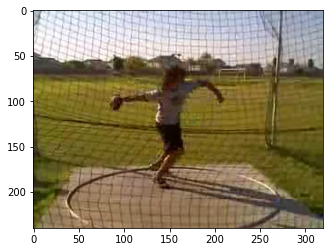

In [ ]:
filename = '/content/Video-Tutorial-CVPR2020/02_sota/ThrowDiscus.png'
img = mx.image.imread(filename)
plt.imshow(img.asnumpy())

In [ ]:
model_name = 'vgg16_ucf101'
net = gluoncv.model_zoo.get_model(model_name, pretrained=True)

Model file is not found. Downloading.


100%|██████████| 500159/500159 [00:10<00:00, 45612.69KB/s]


Model file is not found. Downloading.


486864KB [00:10, 46449.16KB/s]                            


In [ ]:
transform_fn = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor(),
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_list = transform_fn([img.asnumpy()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


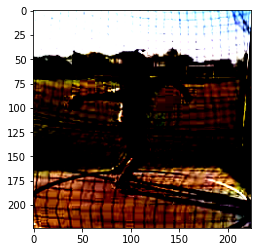

In [ ]:
import numpy as np
plt.imshow(np.transpose(img_list[0], (1, 2, 0)))

In [ ]:
pred = net(nd.array(img_list[0]).expand_dims(axis=0))

In [ ]:
classes = net.classes
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video frame is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video frame is classified to be
	[ThrowDiscus], with probability 0.998.
	[HorseRace], with probability 0.001.
	[VolleyballSpiking], with probability 0.001.
	[Hammering], with probability 0.000.
	[TennisSwing], with probability 0.000.


비디오 분류

In [4]:
video_fname = '/content/Video-Tutorial-CVPR2020/02_sota/v_Basketball_g01_c01.avi'

cap = cv2.VideoCapture(video_fname)
cnt = 0
video_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    cnt += 1
    if ret and cnt % 25 == 0:
        video_frames.append(frame)
    if not ret: break

cap.release()
print('We evenly extract %d frames from the video %s.' % (len(video_frames), video_fname))

We evenly extract 5 frames from the video /content/Video-Tutorial-CVPR2020/02_sota/v_Basketball_g01_c01.avi.


In [ ]:
video_frames_transformed = transform_fn(video_frames)
final_pred = 0
for _, frame_img in enumerate(video_frames_transformed):
    pred = net(nd.array(frame_img).expand_dims(axis=0))
    final_pred += pred
final_pred /= len(video_frames)

classes = net.classes
topK = 5
ind = nd.topk(final_pred, k=topK)[0].astype('int')
print('The input video is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(final_pred)[0][ind[i]].asscalar()))

The input video is classified to be
	[Basketball], with probability 0.978.
	[TennisSwing], with probability 0.020.
	[SoccerJuggling], with probability 0.002.
	[VolleyballSpiking], with probability 0.000.
	[JavelinThrow], with probability 0.000.


더 많은 데이터

In [ ]:
!python /content/Video-Tutorial-CVPR2020/02_sota/ucf101.py --tiny_dataset

100% 49545/49545 [00:00<00:00, 52094.78KB/s]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 839, in _validate_conn
    conn.connect()
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 344, in connect
    ssl_context=context)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/ssl_.py", line 345, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "/usr/lib/python3.7/ssl.py", line 423, in wrap_socket
    session=session
  File "/usr/lib/python3.7/ssl.py", line 870, in _create
    self.do_handshake()
  File "/usr/lib/python3.7/ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
ssl.SS

In [ ]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

In [ ]:
# Get the model vgg16_ucf101 with temporal segment network, with 101 output classes, without pre-trained weights
net = get_model(name='vgg16_ucf101', nclass=101, tsn=True, num_segments=3)

In [ ]:
net.collect_params().reset_ctx(ctx)

MXNetError: ignored